In [13]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training/KRS'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training/KRS


### Import libraries

In [14]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import sys
# sys.path.insert(0, '../models')
# from krs_inflow_model import SimpleMLP

### Read Datasets

In [15]:
inflow_df = pd.read_csv('../../dataset/reservoir_dataset_engg.csv')
inflow_df = inflow_df[inflow_df['RESERVOIR'] == 'K.R.S']
print(inflow_df.shape)
inflow_df.head()

(3274, 9)


,RESERVOIR,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,DAY
0,K.R.S,46.42,122.59,2029.0,2000.0,2011,1,1,0
1,K.R.S,46.54,122.68,3084.0,1490.0,2011,1,2,1
2,K.R.S,46.64,122.75,2776.0,1491.0,2011,1,3,2
3,K.R.S,46.69,122.79,2311.0,1491.0,2011,1,4,3
4,K.R.S,46.70,122.80,1847.0,1491.0,2011,1,5,4


In [16]:
rainfall_departure_df = pd.read_csv('../../dataset/Rainfall 2010-2020/rainfall_departure_dataset.csv')
print(rainfall_departure_df.shape)
rainfall_departure_df.head()

(4004, 6)


,DISTRICTS,RAINFALL,YEAR,MONTH,DEPARTURE,SEASON
0,BAGALKOTE,0.0,2008,1,-100.0,WINTER
1,BELLARY,0.0,2008,1,-100.0,WINTER
2,KOLAR,0.0,2008,1,-100.0,WINTER
3,GULBARGA,0.0,2008,1,-100.0,WINTER
4,BANGALORE URBAN,0.1,2008,1,-88.0,WINTER


### Dataset Transformation

In [17]:
inflow_df = inflow_df.drop(columns=['RESERVOIR', 'PRESENT_STORAGE_TMC', 'RES_LEVEL_FT', 'OUTFLOW_CUECS', 'DATE'])
inflow_df.head()

,INFLOW_CUSECS,YEAR,MONTH,DAY
0,2029.0,2011,1,0
1,3084.0,2011,1,1
2,2776.0,2011,1,2
3,2311.0,2011,1,3
4,1847.0,2011,1,4


In [18]:
rainfall_departure_df = rainfall_departure_df[rainfall_departure_df['DISTRICTS'] == 'KODAGU']
rainfall_departure_df['YEAR'] = rainfall_departure_df['YEAR'].astype(float)
rainfall_departure_df['MONTH'] = rainfall_departure_df['MONTH'].astype(float)
rainfall_departure_df.shape

(156, 6)

### Dataset and DataLoader

In [19]:
month_le = LabelEncoder().fit(inflow_df['MONTH'].unique())
day_le = LabelEncoder().fit(inflow_df['DAY'].unique())
season_le = LabelEncoder().fit(rainfall_departure_df['SEASON'].unique())

In [20]:
train_inflow_df = inflow_df[inflow_df['YEAR'] < 2020]
val_inflow_df = inflow_df[inflow_df['YEAR'] == 2020]

train_inflow_df.shape, val_inflow_df.shape

((2944, 4), (330, 4))

In [27]:
class InflowDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __getitem__(self, index):
        inflow, year, month, day = self.df.iloc[index].values
        _, monthly_rainfall, year, month, departure, season = rainfall_departure_df[(rainfall_departure_df['YEAR'] == year) & (rainfall_departure_df['MONTH'] == month)].values[0]
        prev_rainfall_departure_df = rainfall_departure_df[(rainfall_departure_df['YEAR'] < year) & (rainfall_departure_df['MONTH'] == month)].sort_values('YEAR', ascending=False).head(3)
        prev_avg_rainfall = prev_rainfall_departure_df['RAINFALL'].values.mean()
        prev_avg_departure = prev_rainfall_departure_df['DEPARTURE'].values.mean()
        
        month_transformed = month_le.transform([month])
        day_transformed = day_le.transform([day])
        season_transformed = season_le.transform([season])

        return (torch.tensor(month_transformed[0]), \
                torch.tensor(day_transformed[0]), \
                torch.tensor(season_transformed[0]), \
                torch.FloatTensor([prev_avg_rainfall, prev_avg_departure])), (torch.FloatTensor([inflow]), torch.FloatTensor([monthly_rainfall]))
    
    def __len__(self):
        return self.df.shape[0]

In [28]:
train_ds = InflowDataset(train_inflow_df)
val_ds = InflowDataset(val_inflow_df)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=8)
val_dl = DataLoader(val_ds, batch_size=32, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Model

In [29]:
class SimpleMLP(nn.Module):
    def __init__(self, nmonth, nday, nseason, cardinality=3):
        super().__init__()
        self.month_emb = nn.Embedding(num_embeddings=nmonth, embedding_dim=32)
        self.day_emb = nn.Embedding(num_embeddings=nday, embedding_dim=32)
        self.season_emb = nn.Embedding(num_embeddings=nseason, embedding_dim=32)
        self.prev_data_layer = nn.Sequential(
            nn.Linear(in_features=2, out_features=16),
            nn.SELU(),
            nn.Linear(in_features=16, out_features=32),
            nn.SELU()
        )

        self.conv_1 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.res_layer_1 = nn.Sequential(
            nn.BatchNorm2d(num_features=12),
            nn.SELU(),
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=12),
            nn.SELU(),
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        )
        # self.res_layer_1 = nn.ModuleList([nn.Sequential(
        #     nn.BatchNorm2d(num_features=128*4),
        #     nn.ReLU(),
        #     nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=1)
        #     nn.BatchNorm2d(num_features=128*4),
        #     nn.ReLU(),
        #     nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=1)
        # ) for i in range(cardinality)])
        self.hidden_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=6, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        )
        self.res_layer_2 = nn.Sequential(
            nn.BatchNorm2d(num_features=6),
            nn.SELU(),
            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=6),
            nn.SELU(),
            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=1, padding=1)
        )
        # self.res_layer_2 = nn.ModuleList([nn.Sequential(
        #     nn.BatchNorm2d(num_features=128*2),
        #     nn.ReLU(),
        #     nn.Linear(in_features=128*2, out_features=128*2),
        #     nn.BatchNorm1d(num_features=128*2),
        #     nn.ReLU(),
        #     nn.Linear(in_features=128*2, out_features=128*2),
        # ) for i in range(cardinality)])
        self.hidden_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=1, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        )
        self.rainfall_layer = nn.Sequential(
            nn.Linear(in_features=64, out_features=64),
            nn.LeakyReLU(),
            nn.BatchNorm1d(num_features=64),
            nn.Linear(in_features=64, out_features=32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=1),
            nn.ReLU()
        )
        
        self.inflow_layer = nn.Sequential(
            nn.Linear(in_features=64, out_features=32),
            nn.LeakyReLU(),
            # nn.Linear(in_features=32, out_features=8),
            # nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=1),
            nn.ReLU()
        )
    
    def forward(self, x_month, x_day, x_season, x_prev_data):
        bs = x_month.shape[0]

        month_out = self.month_emb(x_month)
        day_out = self.day_emb(x_day)
        season_out = self.season_emb(x_season)
        prev_data_out = self.prev_data_layer(x_prev_data)

        month_day = torch.bmm(month_out.view(bs, -1, 1), day_out.view(bs, 1, -1))
        month_season = torch.bmm(month_out.view(bs, -1, 1), season_out.view(bs, 1, -1))
        month_prev_data = torch.bmm(month_out.view(bs, -1, 1), prev_data_out.view(bs, 1, -1))
        day_season = torch.bmm(day_out.view(bs, -1, 1), season_out.view(bs, 1, -1))
        day_prev_data = torch.bmm(day_out.view(bs, -1, 1), prev_data_out.view(bs, 1, -1))
        season_prev_data = torch.bmm(season_out.view(bs, -1, 1), prev_data_out.view(bs, 1, -1))

        x = torch.stack([month_day, month_season, month_prev_data, day_season, day_prev_data, season_prev_data], axis=1)
        conv_out = self.conv_1(x)
        res_out_1 = self.res_layer_1(conv_out) + conv_out
        hidden_out_1 = self.hidden_layer_1(res_out_1)
        res_out_2 = self.res_layer_2(hidden_out_1) + hidden_out_1
        hidden_out_2 = self.hidden_layer_2(res_out_2)
        hidden_out_2 = hidden_out_2.view(bs, -1)
        
        rainfall_out = self.rainfall_layer(hidden_out_2)
        inflow_out = self.inflow_layer(hidden_out_2)

        return rainfall_out, inflow_out#.view(bs)
    
    def weight_init(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight)

### Training

In [30]:
def train(model, epochs, lr):
    opt = Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(opt, patience=10, min_lr=1e-8)
    criterion = nn.MSELoss()

    mean_inflow = train_inflow_df['INFLOW_CUSECS'].mean()
    mean_rainfall = rainfall_departure_df['RAINFALL'].mean()
    inflow_loss_weight = int((mean_inflow + mean_rainfall) / mean_inflow)
    rainfall_loss_weight = int((mean_inflow + mean_rainfall) / mean_rainfall)
    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0

        model.train()
        for xb, yb in train_dl:
            x_month = xb[0].cuda()
            x_day = xb[1].cuda()
            x_season = xb[2].cuda()
            x_prev_data = xb[3].cuda()
            y_inflow = yb[0].cuda()
            y_rainfall = yb[1].cuda()

            y_hat = model(x_month, x_day, x_season, x_prev_data)
            y_hat_rainfall = y_hat[0]
            y_hat_inflow = y_hat[1]
            loss = rainfall_loss_weight * criterion(y_hat_rainfall, y_rainfall) + inflow_loss_weight * criterion(y_hat_inflow, y_inflow)
            # loss = criterion(y_hat, y_inflow)

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_loss += loss.item()
        
        model.eval()
        with torch.no_grad():
            for xb, yb in val_dl:
                x_month = xb[0].cuda()
                x_day = xb[1].cuda()
                x_season = xb[2].cuda()
                x_prev_data = xb[3].cuda()
                y_inflow = yb[0].cuda()
                y_rainfall = yb[1].cuda()

                y_hat = model(x_month, x_day, x_season, x_prev_data)
                y_hat_rainfall = y_hat[0]
                y_hat_inflow = y_hat[1]
                loss = rainfall_loss_weight * criterion(y_hat_rainfall, y_rainfall) + inflow_loss_weight * criterion(y_hat_inflow, y_inflow)

                val_loss += loss.item()
                
        scheduler.step(train_loss)

        if scheduler._last_lr[0] <= 1e-06:
            break
        print(f'Epoch - {epoch+1} | LR - {scheduler._last_lr[0]} | Train Loss - {round(train_loss / len(train_dl), 2)} | Val Loss - {round(val_loss / len(val_dl), 2)}')

In [31]:
model = SimpleMLP(len(month_le.classes_), len(day_le.classes_), len(season_le.classes_)).cuda()
model.weight_init()

In [32]:
train(model, epochs=5, lr=1e-02)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch - 1 | LR - 0.01 | Train Loss - 38157391.88 | Val Loss - 17019416.04
Epoch - 2 | LR - 0.01 | Train Loss - 33900825.33 | Val Loss - 28492552.16
Epoch - 3 | LR - 0.01 | Train Loss - 32991457.23 | Val Loss - 19204505.89
Epoch - 4 | LR - 0.01 | Train Loss - 32021600.08 | Val Loss - 13677713.17
Epoch - 5 | LR - 0.01 | Train Loss - 29555127.1 | Val Loss - 28535404.55


In [33]:
train(model, epochs=100, lr=1e-03)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch - 1 | LR - 0.001 | Train Loss - 26029385.24 | Val Loss - 20134707.68
Epoch - 2 | LR - 0.001 | Train Loss - 24922226.36 | Val Loss - 19135821.63
Epoch - 3 | LR - 0.001 | Train Loss - 24563233.62 | Val Loss - 18118916.89
Epoch - 4 | LR - 0.001 | Train Loss - 24373093.19 | Val Loss - 19912470.58
Epoch - 5 | LR - 0.001 | Train Loss - 23680646.86 | Val Loss - 17015647.14
Epoch - 6 | LR - 0.001 | Train Loss - 23508888.98 | Val Loss - 19960151.65
Epoch - 7 | LR - 0.001 | Train Loss - 23355615.04 | Val Loss - 18441357.8
Epoch - 8 | LR - 0.001 | Train Loss - 23098919.74 | Val Loss - 17870409.13
Epoch - 9 | LR - 0.001 | Train Loss - 23038403.82 | Val Loss - 17883118.14
Epoch - 10 | LR - 0.001 | Train Loss - 22611340.94 | Val Loss - 19913822.87
Epoch - 11 | LR - 0.001 | Train Loss - 22774362.9 | Val Loss - 18228702.33
Epoch - 12 | LR - 0.001 | Train Loss - 22166400.78 | Val Loss - 18821070.36
Epoch - 13 | LR - 0.001 | Train Loss - 21999983.78 | Val Loss - 20447787.98
Epoch - 14 | LR - 0.001

In [34]:
model

SimpleMLP(
  (month_emb): Embedding(12, 32)
  (day_emb): Embedding(366, 32)
  (season_emb): Embedding(3, 32)
  (prev_data_layer): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): SELU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): SELU()
  )
  (conv_1): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res_layer_1): Sequential(
    (0): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): SELU()
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): SELU()
    (5): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (hidden_layer_1): Sequential(
    (0): Conv2d(12, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (res_layer_2): Sequential(
    (0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affin

### Prediction on Validation Dataset

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


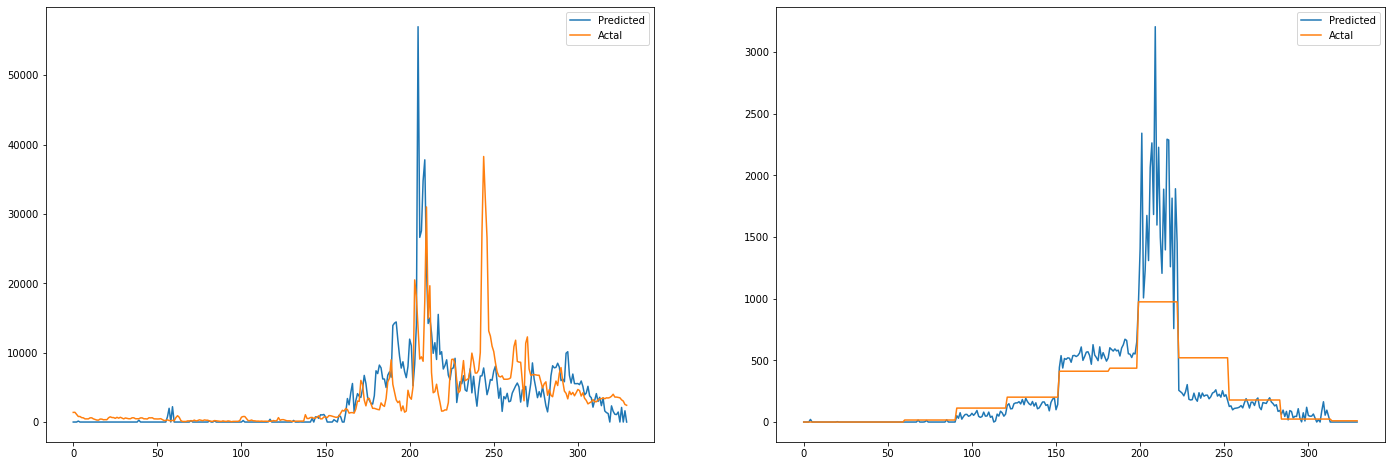

In [35]:
y_actual_rainfall, y_pred_rainfall = [], []
y_actual_inflow, y_pred_inflow = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        x_month = xb[0].cuda()
        x_day = xb[1].cuda()
        x_season = xb[2].cuda()
        x_prev_data = xb[3].cuda()
        y_inflow = yb[0]
        y_rainfall = yb[1]

        y_hat = model(x_month, x_day, x_season, x_prev_data)
        y_hat_rainfall = y_hat[0]
        y_hat_inflow = y_hat[1]

        y_actual_rainfall += y_rainfall.data.tolist()
        y_actual_inflow += y_inflow.data.tolist()
        y_pred_rainfall += y_hat_rainfall.cpu().data.tolist()
        y_pred_inflow += y_hat_inflow.cpu().data.tolist()

y_actual_rainfall = np.array(y_actual_rainfall).flatten()
y_actual_inflow = np.array(y_actual_inflow).flatten()
y_pred_rainfall = np.array(y_pred_rainfall).flatten()
y_pred_inflow = np.array(y_pred_inflow).flatten()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,8))
ax1.plot(y_pred_inflow, label='Predicted')
ax1.plot(y_actual_inflow, label='Actal')
ax1.legend()
ax2.plot(y_pred_rainfall, label='Predicted')
ax2.plot(y_actual_rainfall, label='Actal')
ax2.legend()
plt.show()

### Prediction on entire Dataset

In [36]:
def pred(df):
    pred_ds = InflowDataset(df.copy())
    pred_dl = DataLoader(pred_ds, batch_size=len(pred_ds))

    model.eval()
    with torch.no_grad():
        for x, y in pred_dl:
            x_month = x[0].cuda()
            x_day = x[1].cuda()
            x_season = x[2].cuda()
            x_prev_data = x[3].cuda()
            y_inflow = yb[0]
            y_rainfall = yb[1]

            y_hat = model(x_month, x_day, x_season, x_prev_data)
            y_hat_rainfall = y_hat[0]
            y_hat_inflow = y_hat[1]

    return y_hat_inflow.data.cpu().view(-1).tolist(), y_hat_rainfall.data.cpu().view(-1).tolist()
    # return y_hat.data.cpu().view(-1).tolist()

In [39]:
model_test_df = inflow_df.sort_values(by=['YEAR', 'DAY']).copy()
model_test_df['Predicted_Inflow'], model_test_df['Predicted_Rainfall'] = pred(model_test_df)
# model_test_df['Predicted_Inflow'] = pred(model_test_df)
model_test_df[:10]

,INFLOW_CUSECS,YEAR,MONTH,DAY,Predicted_Inflow,Predicted_Rainfall
0,2029.0,2011,1,0,2276.695312,0.0
1,3084.0,2011,1,1,2138.556396,0.0
2,2776.0,2011,1,2,2754.599609,0.0
3,2311.0,2011,1,3,2676.283936,0.0
4,1847.0,2011,1,4,1745.444336,0.0
5,2156.0,2011,1,5,2320.929688,0.0
6,1847.0,2011,1,6,1653.333740,0.0
7,2002.0,2011,1,7,1965.712036,0.0
8,1537.0,2011,1,8,1622.863281,0.0
9,1382.0,2011,1,9,1628.947388,0.0


In [42]:
avg_daily_pred_inflow = model_test_df.groupby(['MONTH', 'DAY'])['Predicted_Inflow'].mean().values
avg_daily_actual_inflow = model_test_df.groupby(['MONTH', 'DAY'])['INFLOW_CUSECS'].mean().values
avg_daily_pred_rainfall = model_test_df.groupby(['MONTH'])['Predicted_Rainfall'].mean().values
avg_daily_actual_rainfall = rainfall_departure_df.groupby(['MONTH'])['RAINFALL'].mean().values

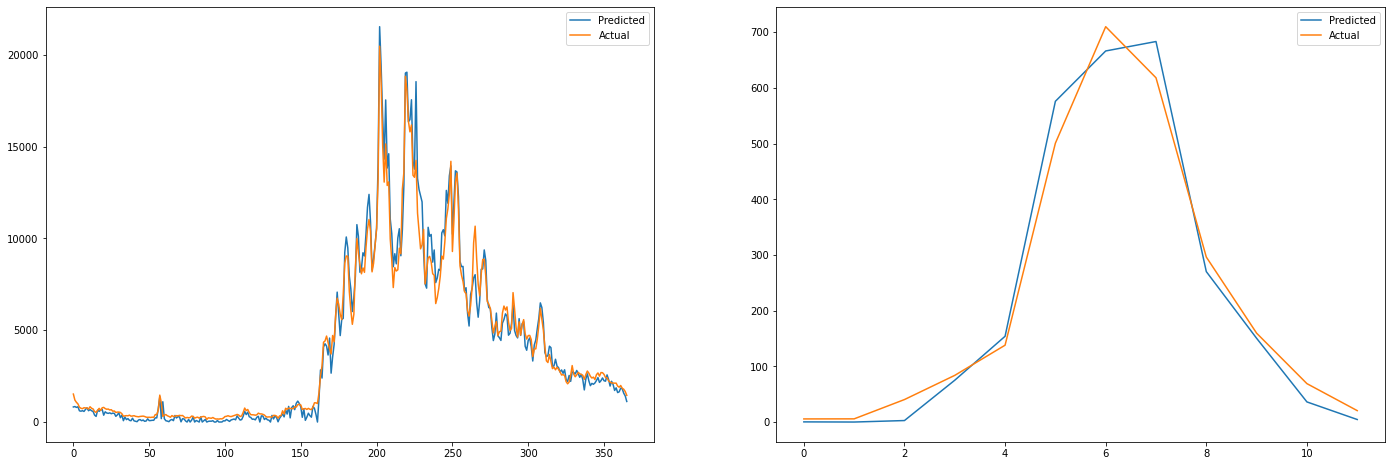

In [43]:
# plt.figure()
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))
ax1.plot(avg_daily_pred_inflow, label='Predicted')
ax1.plot(avg_daily_actual_inflow, label='Actual')
ax1.legend()
ax2.plot(avg_daily_pred_rainfall, label='Predicted')
ax2.plot(avg_daily_actual_rainfall, label='Actual')
ax2.legend()
plt.show()

In [44]:
model_test_df['Predicted_Rainfall'].describe()

count    3274.000000
mean      226.107746
std       299.450346
min         0.000000
25%         0.000000
50%       120.126797
75%       421.352264
max      3206.936523
Name: Predicted_Rainfall, dtype: float64

In [45]:
rainfall_departure_df['RAINFALL'].describe()

count     156.000000
mean      220.685897
std       287.744814
min         0.000000
25%        13.800000
50%       103.800000
75%       314.500000
max      1318.100000
Name: RAINFALL, dtype: float64

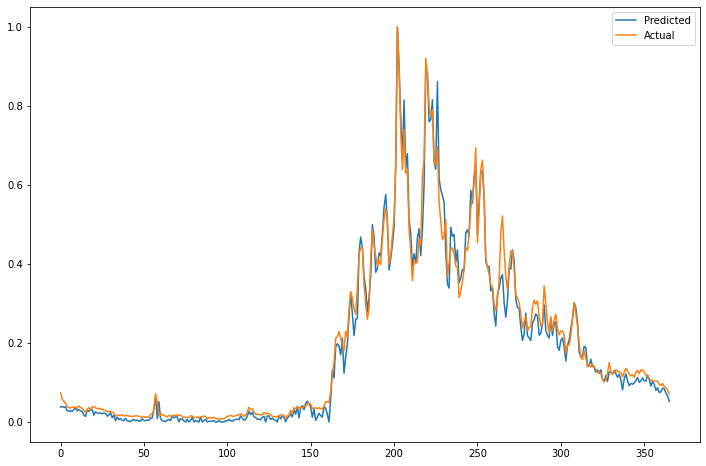

In [46]:
plt.figure(figsize=(12, 8))
plt.plot(avg_daily_pred_inflow / avg_daily_pred_inflow.max(), label='Predicted')
plt.plot(avg_daily_actual_inflow / avg_daily_actual_inflow.max(), label='Actual')

plt.legend()
plt.show()

In [49]:
model_test_df.sort_values(by=['YEAR', 'MONTH', 'DAY'], inplace=True)

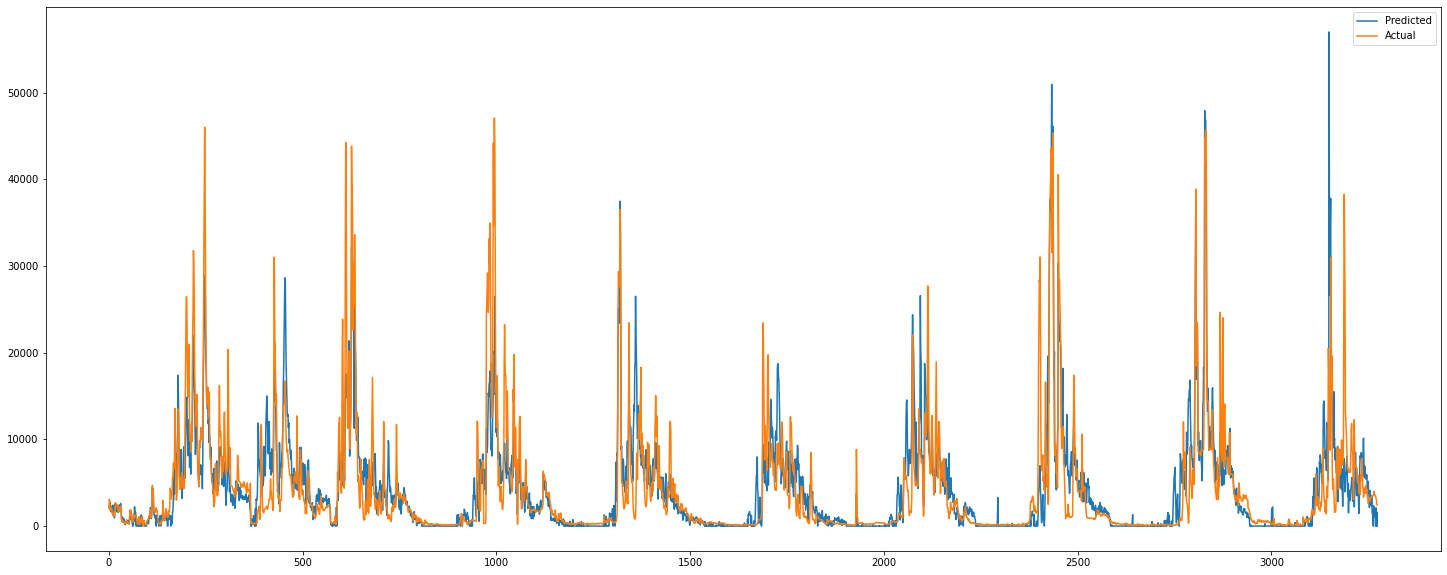

In [50]:
plt.figure(figsize=(25, 10))
plt.plot(model_test_df['Predicted_Inflow'], label='Predicted')
plt.plot(model_test_df['INFLOW_CUSECS'], label='Actual')
plt.legend()
plt.show()

In [51]:
pred_rainfall_df = model_test_df[['YEAR', 'MONTH', 'Predicted_Rainfall']].groupby(['YEAR', 'MONTH']).mean().reset_index()
rainfall_with_pred_df = rainfall_departure_df.merge(pred_rainfall_df, on=['YEAR', 'MONTH'])
rainfall_with_pred_df = rainfall_with_pred_df.sort_values(by=['YEAR', 'MONTH']).reset_index()
rainfall_with_pred_df

,index,DISTRICTS,RAINFALL,YEAR,MONTH,DEPARTURE,SEASON,Predicted_Rainfall
0,0,KODAGU,0.7,2011.0,1.0,-80.0,WINTER,0.000000
1,10,KODAGU,22.2,2011.0,2.0,429.0,WINTER,1.555517
2,19,KODAGU,13.2,2011.0,3.0,-29.0,SUMMER,1.844155
3,27,KODAGU,138.5,2011.0,4.0,54.0,SUMMER,149.749916
4,35,KODAGU,107.5,2011.0,5.0,-30.0,SUMMER,160.838147
...,...,...,...,...,...,...,...,...
109,73,KODAGU,974.9,2020.0,8.0,66.0,MONSOON,1697.376526
110,83,KODAGU,521.1,2020.0,9.0,126.0,MONSOON,219.280217
111,93,KODAGU,178.7,2020.0,10.0,-14.0,WINTER,139.748251
112,103,KODAGU,24.1,2020.0,11.0,-69.0,WINTER,55.904455


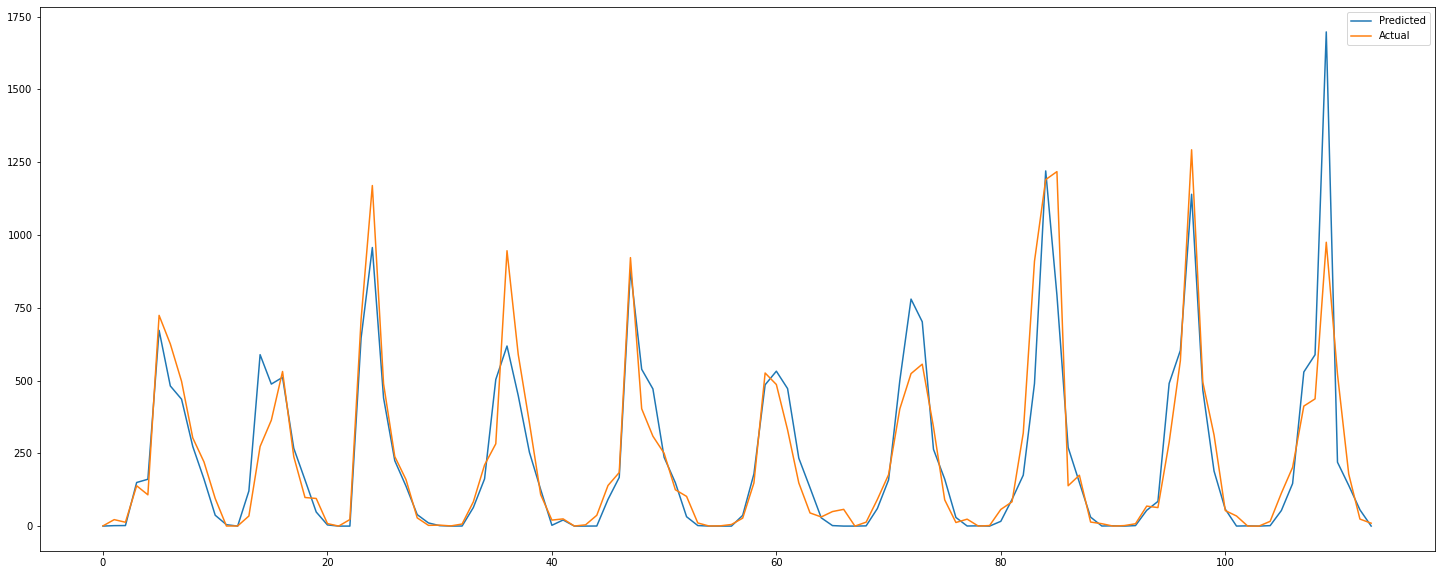

In [52]:
plt.figure(figsize=(25, 10))
plt.plot(rainfall_with_pred_df['Predicted_Rainfall'], label='Predicted')
plt.plot(rainfall_with_pred_df['RAINFALL'], label='Actual')
plt.legend()
plt.show()

In [53]:
train_data_with_pred = model_test_df[model_test_df['YEAR'] < 2020]
val_data_with_pred = model_test_df[model_test_df['YEAR'] == 2020]
train_data_with_pred.shape, val_data_with_pred.shape

((2944, 6), (330, 6))

In [54]:
train_rainfall_with_pred = rainfall_with_pred_df[rainfall_with_pred_df['YEAR'] < 2020]
val_rainfall_with_pred = rainfall_with_pred_df[rainfall_with_pred_df['YEAR'] == 2020]
train_rainfall_with_pred.shape, val_rainfall_with_pred.shape

((102, 8), (12, 8))

In [55]:
((train_data_with_pred['INFLOW_CUSECS'] - train_data_with_pred['Predicted_Inflow']) ** 2).mean() ** .5# + ((train_rainfall_with_pred['RAINFALL'] - train_rainfall_with_pred['Predicted_Rainfall']) ** 2).mean() ** .5      

3624.5026905757695

In [56]:
((val_data_with_pred['INFLOW_CUSECS'] - val_data_with_pred['Predicted_Inflow']) ** 2).mean() ** .5# + ((val_rainfall_with_pred['RAINFALL'] - val_rainfall_with_pred['Predicted_Rainfall']) ** 2).mean() ** .5      

5189.362217820211

In [ ]:
# torch.save(model.state_dict(), 'inflow_rainfall_multihead_model.pth')